### 컬러 이미지 복원

In [1]:
# 오토인코더를 활용하여 흑백이미지를 컬러 이미지로 복원

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()

In [24]:
x_train.shape

(50000, 32, 32, 3)

In [3]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

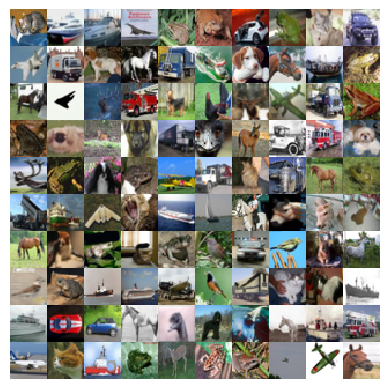

In [4]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.imshow(imgs, interpolation='none')

plt.show()

In [5]:
# 컬러이미지를 흑백이미지로 변환

# grayscale = 0.299*red + 0.587*green + 0.114*blue
# ... 모든 차원

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
#                    (...)모든값

In [6]:
x_train[...,:3][0].shape

(32, 32, 3)

In [7]:
a=np.array([1,2,3,4,5,6]).reshape(1,2,3)
print(a)
print(a.shape)

b=np.array([1,2,2,1,3,1]).reshape(3,2)
print(b)
print(b.shape)

c=np.dot(a,b)
print(c)
print(c.shape)

[[[1 2 3]
  [4 5 6]]]
(1, 2, 3)
[[1 2]
 [2 1]
 [3 1]]
(3, 2)
[[[14  7]
  [32 19]]]
(1, 2, 2)


In [8]:
# 컬러이미지를 흑백으로 변환

x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

In [9]:
x_train_gray.shape # 흑백 이미지

(50000, 32, 32)

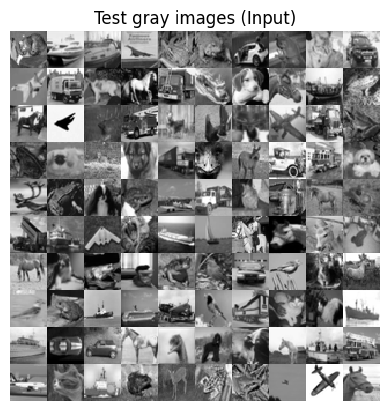

In [10]:
# 흑백 이미지

imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')

plt.show()

In [11]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [12]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [13]:
input_shape = (img_rows, img_cols, 1)

batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

In [14]:
# 1.인코더 모델

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)

latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

In [15]:
# 2. 디코더 모델

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)       7379

In [16]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 모형을 저장할 디렉토리

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'

if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

filepath = os.path.join(save_dir, model_name)

In [18]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=2,
                batch_size=batch_size,
                callbacks=[lr_reducer, checkpoint]) 

Epoch 1/2
1563/1563 [==============================] - ETA: 0s - loss: 0.0155
Epoch 1: val_loss improved from inf to 0.01091, saving model to c:\workspace3\230911\saved_models\colorized_ae_model.001.h5
1563/1563 [==============================] - 44s 27ms/step - loss: 0.0155 - val_loss: 0.0109 - lr: 0.0010
Epoch 2/2
1561/1563 [============================>.] - ETA: 0s - loss: 0.0101
Epoch 2: val_loss improved from 0.01091 to 0.00932, saving model to c:\workspace3\230911\saved_models\colorized_ae_model.002.h5
1563/1563 [==============================] - 41s 26ms/step - loss: 0.0101 - val_loss: 0.0093 - lr: 0.0010


In [19]:
x_decoded = autoencoder.predict(x_test_gray, batch_size=8)

1250/1250 [==============================] - 5s 4ms/step


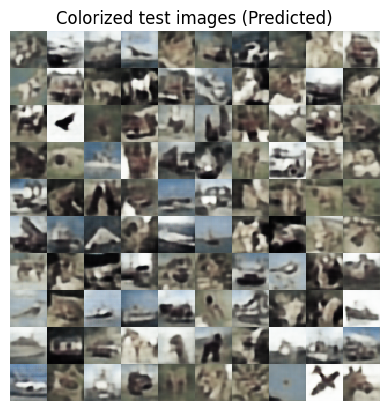

In [20]:
# 복원된 컬러 이미지 출력

imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')

plt.show()